In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from spe.estimators import kfoldcv, kmeanscv, cp_arbitrary, simple_train_test_split
from spe.relaxed_lasso import RelaxedLasso
from spe.cov_estimation import est_Sigma

In [2]:
np.random.seed(1)

In [3]:
nv_df = pd.read_csv('../datasets/NV_SMU_wells_shared_kevin_prep_Nov6.csv')
# nm_df = pd.read_csv('../datasets/NM_SMU_wells_shared_kevin_prep_Nov6.csv')

In [4]:
nv_df

,OBJECTID,Temp_C,Depth_m,GeothermGrad,X_83UTM11_round,Y_83UTM11_round,row,column,id_rc,X_83UTM11,...,Hillshade-100m,DEM-30m,Fairway,Domain,T37,QuaternaryFaultDistance,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate
0,1,115.56,30.5,3645.0,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
1,2,115.56,30.5,3645.0,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
2,119,63.79,64.0,984.4,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
3,120,63.79,64.0,984.4,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
4,123,67.09,54.9,950.9,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,4818,15.80,108.8,24.8,293000.0,4497000.0,952.0,25.0,R953C26,292577.690182,...,179,1195,41.517601,0,12,2.386731,0.907021,0.641172,0.957744,0.713252
3322,4821,0.00,350.0,24.6,680000.0,4326000.0,268.0,1573.0,R269C1574,679577.690182,...,198,2654,38.367802,4,12,0.124746,-0.521456,-0.566835,-0.398600,-0.574790
3323,4822,0.00,350.0,24.6,680000.0,4326000.0,268.0,1573.0,R269C1574,679577.690182,...,198,2654,38.367802,4,12,0.124746,-0.521456,-0.566835,-0.398600,-0.574790
3324,4823,11.20,85.0,24.6,455000.0,4490000.0,924.0,673.0,R925C674,454577.690182,...,191,1713,48.116501,2,12,-0.469778,2.381751,4.019012,0.525528,1.601224


In [5]:
nv_df.columns

Index(['OBJECTID', 'Temp_C', 'Depth_m', 'GeothermGrad', 'X_83UTM11_round',
       'Y_83UTM11_round', 'row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11',
       'NullInfo', 'TrainCodeNeg', 'TrainCodePos', 'TrainCodePosT130',
       'PosSite130_Id', 'PosSite130_Distance', 'PosSite_Id',
       'PosSite_Distance', 'NegSite_Id', 'NegSite_Distance',
       'Local_polygon_Id', 'Local_polygon_overlap_Id', 'QuaternaryFaultTraces',
       'GeodeticStrainRate', 'QuaternarySlipRate', 'FaultRecency',
       'FaultSlipDilationTendency2', 'Earthquakes', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GravityDensity', 'MagneticDensity',
       'Heatflow', 'GeochemistryTemperature2', 'Tufa_Distance',
       'Travertine_Distance', 'Silica_Distance', 'TufaOrTravertine_Distance',
       'FavorableStructuralSettings_Distance', 'Local-StructuralSetting_Error',
       'Local-QuaternaryFaultRecency_Error',
       'Local-QuaternaryFaultSlipDilation_Error',
       'Local-QuaternaryFaultSlipRate_Error

In [6]:
feature_cols = [
    'Depth_m',
    'GeothermGrad',
    'QuaternaryFaultTraces',
    'GeodeticStrainRate',
    'QuaternarySlipRate',
    'FaultRecency',
    'FaultSlipDilationTendency2',
    'Earthquakes',
    'HorizGravityGradient2',
    'HorizMagneticGradient2',
    'GravityDensity',
    'MagneticDensity',
    'Heatflow',
    'Tufa_Distance',
    'Travertine_Distance',
    'Silica_Distance',
    'FavorableStructuralSettings_Distance',
    'QuaternaryFaultDistance',
]
y_cols = 'Temp_C'
loc_cols = ['X_83UTM11_round', 'Y_83UTM11_round']

In [7]:
non_nan_nv_df = nv_df[feature_cols+[y_cols]+loc_cols].dropna(axis=0)

In [8]:
non_nan_nv_df = non_nan_nv_df.drop_duplicates()

In [9]:
non_nan_nv_df.isna().mean()

Depth_m                                 0.0
GeothermGrad                            0.0
QuaternaryFaultTraces                   0.0
GeodeticStrainRate                      0.0
QuaternarySlipRate                      0.0
FaultRecency                            0.0
FaultSlipDilationTendency2              0.0
Earthquakes                             0.0
HorizGravityGradient2                   0.0
HorizMagneticGradient2                  0.0
GravityDensity                          0.0
MagneticDensity                         0.0
Heatflow                                0.0
Tufa_Distance                           0.0
Travertine_Distance                     0.0
Silica_Distance                         0.0
FavorableStructuralSettings_Distance    0.0
QuaternaryFaultDistance                 0.0
Temp_C                                  0.0
X_83UTM11_round                         0.0
Y_83UTM11_round                         0.0
dtype: float64

In [10]:
locs = non_nan_nv_df[loc_cols]
y = non_nan_nv_df[y_cols]
X = non_nan_nv_df[feature_cols]

In [11]:
X.shape

(1502, 18)

In [12]:
X

,Depth_m,GeothermGrad,QuaternaryFaultTraces,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,HorizGravityGradient2,HorizMagneticGradient2,GravityDensity,MagneticDensity,Heatflow,Tufa_Distance,Travertine_Distance,Silica_Distance,FavorableStructuralSettings_Distance,QuaternaryFaultDistance
0,30.500000,3645.00,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.000012,2,8,87.680901,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
2,64.000000,984.40,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.000012,2,8,87.680901,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
4,54.900000,950.90,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.000012,2,8,87.680901,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
6,44.500000,299.00,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.000012,2,8,87.680901,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
8,40.000000,3276.00,0,1.704770,-2.50468,1.31850,0.811184,2.18327,0.004109,0.000015,3,4,112.112999,18981.165796,55655.403494,2079.146084,4759.969447,-0.965216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3313,103.658537,25.48,0,1.236560,-2.16702,2.07204,0.730613,1.75967,0.000117,0.000016,30,8,103.337997,25597.370730,25864.297461,25719.772508,2944.482477,0.161341
3317,30.000000,25.20,1,1.290760,-2.40406,2.33221,0.729968,1.93197,0.003233,0.000011,8,30,83.903900,14604.081515,36589.383774,24774.006808,11119.594912,-1.064303
3320,108.800000,24.80,0,1.343000,-2.45373,1.57206,0.860139,2.24428,0.004033,0.000034,6,2,74.396004,51020.679897,34537.742087,8914.088404,5056.693849,2.386731
3322,350.000000,24.60,0,0.462398,-2.72502,2.45524,0.783172,1.42325,0.000988,0.000017,23,8,78.786400,322268.860515,68016.522897,172065.856774,10037.757911,0.124746


In [13]:
px.scatter(locs, x='X_83UTM11_round', y='Y_83UTM11_round', width=800, height=800)

In [14]:
y.describe()

count    1502.000000
mean       31.767195
std        35.346381
min         0.000000
25%        16.212500
50%        22.480000
75%        33.200000
max       283.700000
Name: Temp_C, dtype: float64

In [15]:
(y == 0).sum(), (y == 0).mean()

(np.int64(218), np.float64(0.14513981358189082))

<Axes: >

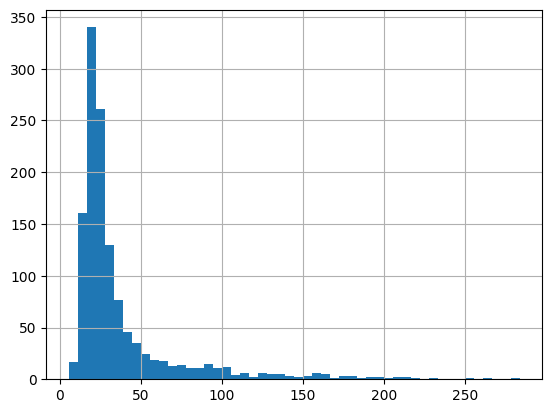

In [16]:
y[y != 0].hist(bins=50)

<Axes: >

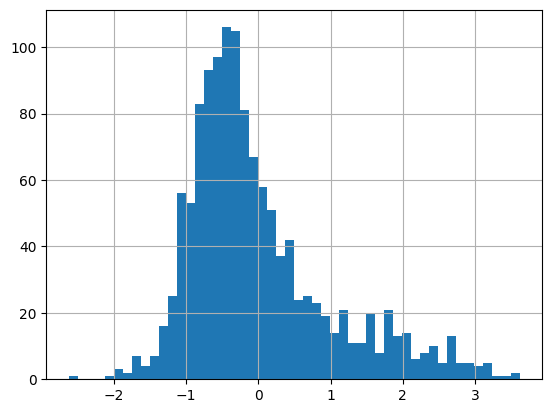

In [17]:
((np.log(y[y != 0]) - np.log(y[y != 0]).mean()) / (np.log(y[y != 0]).std())).hist(bins=50)

### NOT normal, but shouldn't be because sampling is not random and this is not conditional on $X$.

In [18]:
filtered_nv_df = non_nan_nv_df[y != 0]
filtered_nv_df = filtered_nv_df.drop_duplicates() ## found lots of duplicates (~40%)
filtered_nv_df = filtered_nv_df.drop_duplicates(subset=["X_83UTM11_round", "Y_83UTM11_round"]) ## even within this there are duplicated locations (~20%)

locs = filtered_nv_df[loc_cols]
y = np.log(filtered_nv_df[y_cols])
# y = filtered_nv_df[y_cols]
X = filtered_nv_df[feature_cols]

In [19]:
X.shape, y.shape, locs.shape

((1009, 18), (1009,), (1009, 2))

In [ ]:
## GenCp parameters
niter = 10
alpha = .05
nboot = 100
k = 10

models = [
    XGBRegressor(
        max_depth=2, 
        n_estimators=100
    ), 
    XGBRegressor(
        max_depth=6, 
        n_estimators=100
    ), 
    RandomForestRegressor(
        max_depth=2, 
        max_features='sqrt',
        n_estimators=100
    ),
    RandomForestRegressor(
        max_depth=6, 
        max_features='sqrt',
        n_estimators=100
    ),
    ElasticNetCV()
]

## plot parameters
title = "General Model Comparisons"
est_names = ["XGB2", "XGB6", "RF2", "RF6", "ENetCV"]
# model_names = ["Lasso CV"]

In [21]:
from sklearn.tree import DecisionTreeRegressor
import skgstat as skg
from scipy.spatial import distance_matrix

# Estimate Covariance

In [22]:
est_sigma_model = RandomForestRegressor(
    max_depth=3, 
    max_features='sqrt'
)
est_Chol_SSN, est_Cov_SSN = est_Sigma(
    X,
    y,
    locs,
    est_sigma='corr_resp',
    est_sigma_model=est_sigma_model,
)

# In-sample

## Model Comparison

In [23]:
errs_SSN = []
for model in models:
    err = []
    for i in tqdm(range(niter)):
        e = cp_arbitrary(
            model=model,
            X=X, 
            y=y,
            tr_idx=np.ones_like(y),
            use_trace_corr=False,
            Chol_y=est_Chol_SSN,
            Cov_y_ystar=est_Cov_SSN,
            nboot=nboot,
            alpha=alpha,
        )
        err.append(e)
    errs_SSN.append(err)

100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


In [ ]:
cv_errs = []
for model in models:
    err = []
    for i in tqdm(range(niter)):
        e = kmeanscv(
            model=model,
            X=X, 
            y=y,
            coord=locs,
            k=k,
        )
        err.append(e)
    cv_errs.append(err)

100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


In [ ]:
fig_SSN = make_subplots(
    rows=1, cols=1
)

df_SSN = pd.DataFrame({est_names[i]: errs_SSN[i] for i in np.arange(len(est_names))})

fig_SSN.add_trace(go.Bar(
    x=df_SSN.columns,
    y=df_SSN.mean(),
    marker_color=px.colors.qualitative.Bold[0],
    text=np.around(df_SSN.mean(),3),
    textposition='outside',
    error_y=dict(
        type='data',
        color='black',
        array=df_SSN.std(),
    ),
    name="GenCp"
), row=1, col=1)

df_cv = pd.DataFrame({est_names[i]: cv_errs[i] for i in np.arange(len(est_names))})

fig_SSN.add_trace(go.Bar(
    x=df_cv.columns,
    y=df_cv.mean(),
    marker_color=px.colors.qualitative.Bold[2],
    text=np.around(df_cv.mean(),3),
    textposition='outside',
    error_y=dict(
        type='data',
        color='black',
        array=df_cv.std(),
    ),
    name="SPCV"
), row=1, col=1)

fig_SSN.update_yaxes(title_text="GenCp Estimated MSE", row=1, col=1)
fig_SSN.update_layout(title_text="Nevada Data: In-Sample Model Comparison", barmode="group")
fig_SSN.show()

In [ ]:
fig_SSN = make_subplots(
    rows=1, cols=1
)

df_SSN = pd.DataFrame({est_names[i]: errs_SSN[i] for i in np.arange(len(est_names))})

fig_SSN.add_trace(go.Bar(
    x = df_SSN.columns,
    y=df_SSN.mean(),
    marker_color=px.colors.qualitative.Bold[0],
    text=np.around(df_SSN.mean(),3),
    textposition='outside',
    error_y=dict(
        type='data',
        color='black',
        array=df_SSN.std(),
    )
), row=1, col=1)

fig_SSN.update_yaxes(title_text="GenCp Estimated MSE", row=1, col=1)
fig_SSN.update_layout(title_text="Nevada Data: In-Sample Model Comparison", showlegend=False)
fig_SSN.show()

In [ ]:
fig_CV = make_subplots(
    rows=1, cols=1
)

df_CV = pd.DataFrame({est_names[i]: errs_SSN[i + len(est_names)] for i in np.arange(len(est_names))})

fig_CV.add_trace(go.Bar(
    x=df_CV.columns,
    y=df_CV.mean(),
    marker_color=px.colors.qualitative.Bold[2],
    text=np.around(df_CV.mean(),3),
    textposition='outside',
    error_y=dict(
        type='data',
        color='black',
        array=df_CV.std(),
    )
), row=1, col=1)

fig_CV.update_yaxes(title_text=f"{k}-SPCV Estimated MSE", row=1, col=1)
fig_CV.update_layout(title_text="Nevada Data: In-Sample Model Comparison", showlegend=False)
fig_CV.show()

In [28]:
fig_CV2 = make_subplots(
    rows=1, cols=1
)

df_CV2 = pd.DataFrame({est_names[i]: errs_SSN[i + 2*len(est_names)] for i in np.arange(len(est_names))})

fig_CV2.add_trace(go.Bar(
    x = df_CV2.columns,
    y=df_CV2.mean(),
    marker_color=px.colors.qualitative.Bold[2],
    text=np.around(df_CV2.mean(),3),
    textposition='outside',
    error_y=dict(
        type='data',
        color='black',
        array=df_CV2.std(),
    )
), row=1, col=1)

fig_CV2.update_yaxes(title_text="3-SPCV Estimated MSE", row=1, col=1)
fig_CV2.update_layout(title_text="Nevada Data: In-Sample Model Comparison", showlegend=False)
fig_CV2.show()